In [1]:
import dask.dataframe as dd
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0,0,0,0),(0,1,0,1),(1,0,0,1)], N=128)

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 976.96 GB


# Problem size

In [3]:
n_samples = 200_000_000
distance_mean_m = 100
distance_sigma_m = 10
time_mean_s = 10
time_sigma_s = 0.1

# Pandas approach

In [4]:
df1 = pd.DataFrame(
    {
        "distance_m" : np.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples),
        "time_s": np.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples)
    }
)

In [5]:
df1.head()

,distance_m,time_s
0,106.506745,9.933894
1,103.018281,9.979532
2,98.289122,9.828461
3,87.432827,10.148760
4,86.020655,10.062543


In [6]:
# size of df1 in GB
df1.memory_usage(deep=True).sum() / (1024 ** 3)

np.float64(2.980232361704111)

In [7]:
hist_pandas, xedges_pandas, yedges_pandas = np.histogram2d(
    df1.distance_m,
    df1.time_s,
    bins=500)

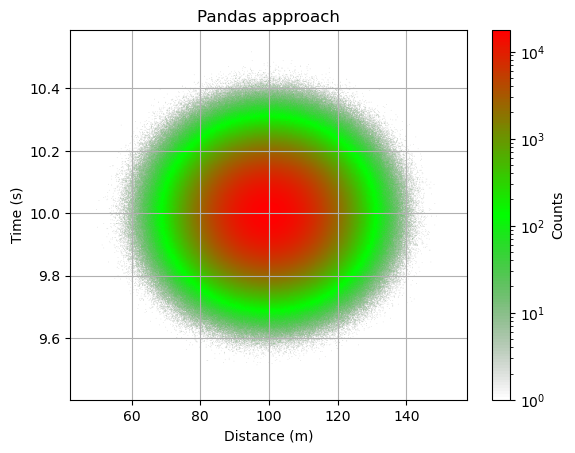

In [8]:
norm = mcolors.LogNorm(vmin=1, vmax=hist_pandas.max())

plt.imshow(
    hist_pandas.T,
    origin="lower",
    aspect="auto",
    extent=[xedges_pandas[0], xedges_pandas[-1], yedges_pandas[0], yedges_pandas[-1]],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.title("Pandas approach")
plt.colorbar(label="Counts")
plt.grid()

# Dask approach

In [9]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35957,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36911,Total threads: 1
Dashboard: http://127.0.0.1:41239/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:37481,


In [10]:
import dask.array as da
import dask.dataframe as dd

distance_m_dask = da.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples, chunks='auto')
time_s_dask = da.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples, chunks='auto')
df2 = dd.from_dask_array(da.stack([distance_m_dask, time_s_dask], axis=1), columns=['distance_m', 'time_s'])

In [14]:
x = df2.distance_m.to_dask_array(lengths=True)
y = df2.time_s.to_dask_array(lengths=True)

# Compute min/max first
x_min, x_max, y_min, y_max = da.compute(x.min(), x.max(), y.min(), y.max())

# Use the computed numbers
hist_dask, xedges_dask, yedges_dask = da.histogram2d(
    x, y,
    bins=(500, 500),
    range=[[x_min, x_max], [y_min, y_max]]
)

In [21]:
hist_dask, xedges_dask, yedges_dask = da.compute(hist_dask, xedges_dask, yedges_dask)

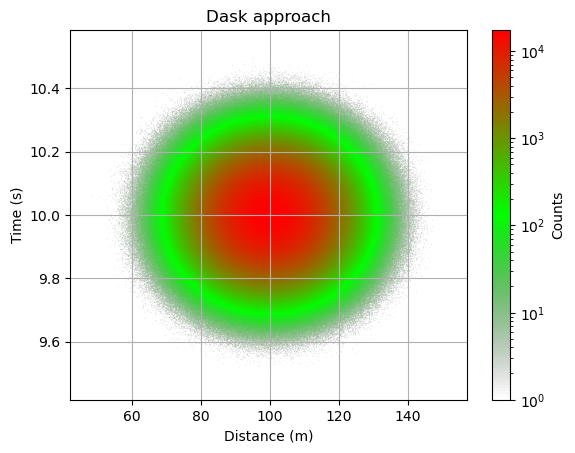

In [22]:
norm = mcolors.LogNorm(vmin=1, vmax=hist_dask.max())

plt.imshow(
    hist_dask.T,
    origin="lower",
    aspect="auto",
    extent=[xedges_dask[0], xedges_dask[-1], yedges_dask[0], yedges_dask[-1]],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.title("Dask approach")
plt.colorbar(label="Counts")
plt.grid()